In [1]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
import torch as th
import numpy as np
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
from collections import Counter
device = th.device("cuda" if th.cuda.is_available() else "cpu" )



In [ ]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT 
model = fasterrcnn_resnet50_fpn(weights=None).to(device)

num_classes = 10
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(th.load("./checkpoint/digit_detection.pt",map_location="cuda"))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]
<ipython-input-2-2b1a497ad236>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

<All keys matched successfully>

In [3]:
model = model.to(device)

In [ ]:
data0 = np.load("./input/multidigittrainingdata/DL-Project/data0.npy")
data1 = np.load("./input/multidigittrainingdata/DL-Project/data1.npy")
data2 = np.load("./input/multidigittrainingdata/DL-Project/data2.npy")
lab0  = np.load("./input/multidigittrainingdata/DL-Project/lab0.npy")
lab1  = np.load("./input/multidigittrainingdata/DL-Project/lab1.npy") 
lab2  = np.load("./input/multidigittrainingdata/DL-Project/lab2.npy") 

sumtest_data = np.concatenate((data0,data1,data2))
sumtest_sums = np.concatenate((lab0,lab1,lab2))

print(sumtest_data.shape,sumtest_sums.shape)
sumtest_data = np.pad(sumtest_data,((0,0),(24,0),(0,0)),constant_values=0)

print(sumtest_data.shape)

class DigitSumDataset(Dataset):
    def __init__(self,images,sums):
        self.images =images/255
        self.sums = sums
    def __len__(self):
        return(len(self.sums))
    def __getitem__(self,idx):
        img = self.images[idx] 
        stdimg = np.std(img)
        img = (img - np.mean(img))/stdimg ## normalizing it
        return(th.tensor(img).unsqueeze(0).float(),self.sums[idx])

sumtestset = DigitSumDataset(sumtest_data[:5000,:,:],sumtest_sums[:5000])
sumtestloader = DataLoader(sumtestset,batch_size=32)

(30000, 40, 168) (30000,)
(30000, 64, 168)


Epoch 0 test:  63%|██████▎   | 99/157 [02:45<01:35,  1.65s/it, accuracy=0.872]

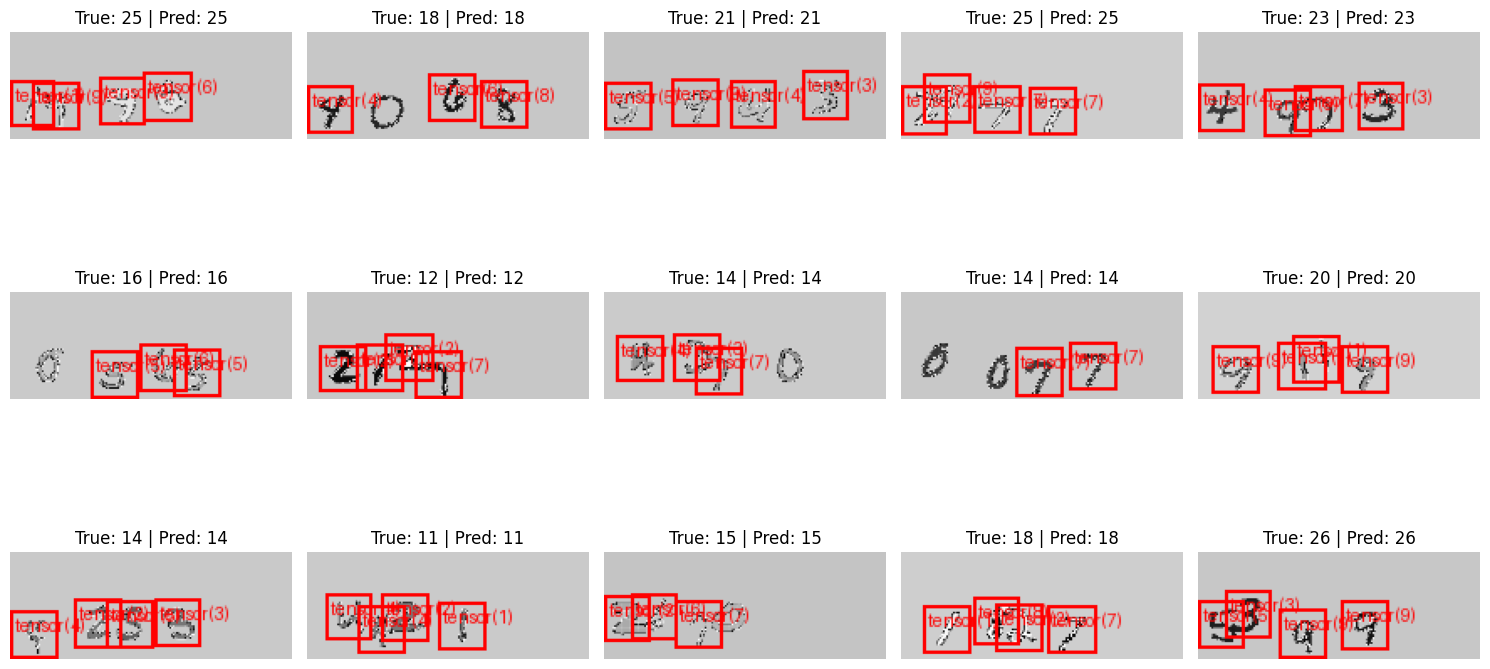

Epoch 0 test: 100%|██████████| 157/157 [04:19<00:00,  1.65s/it, accuracy=0.873]


Total Samples: 5000
Correct Predictions: 4366
Overall Accuracy: 0.87
Mean Error: -0.53
Standard Deviation of Error: 2.06
Total Errors: 5000


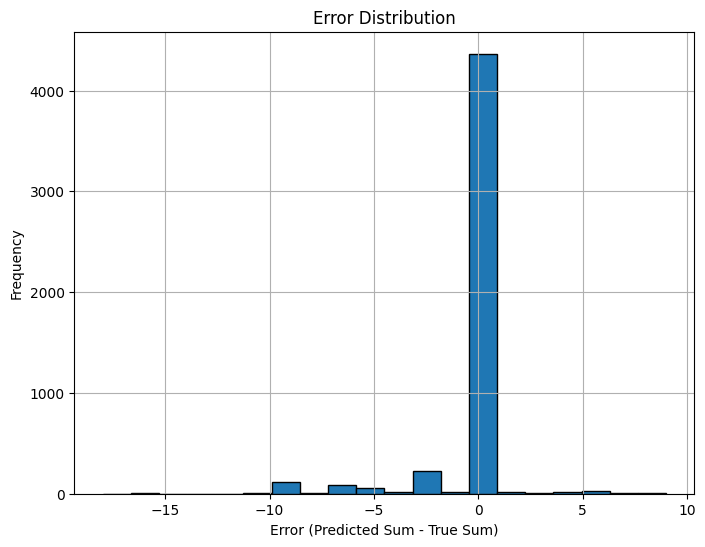

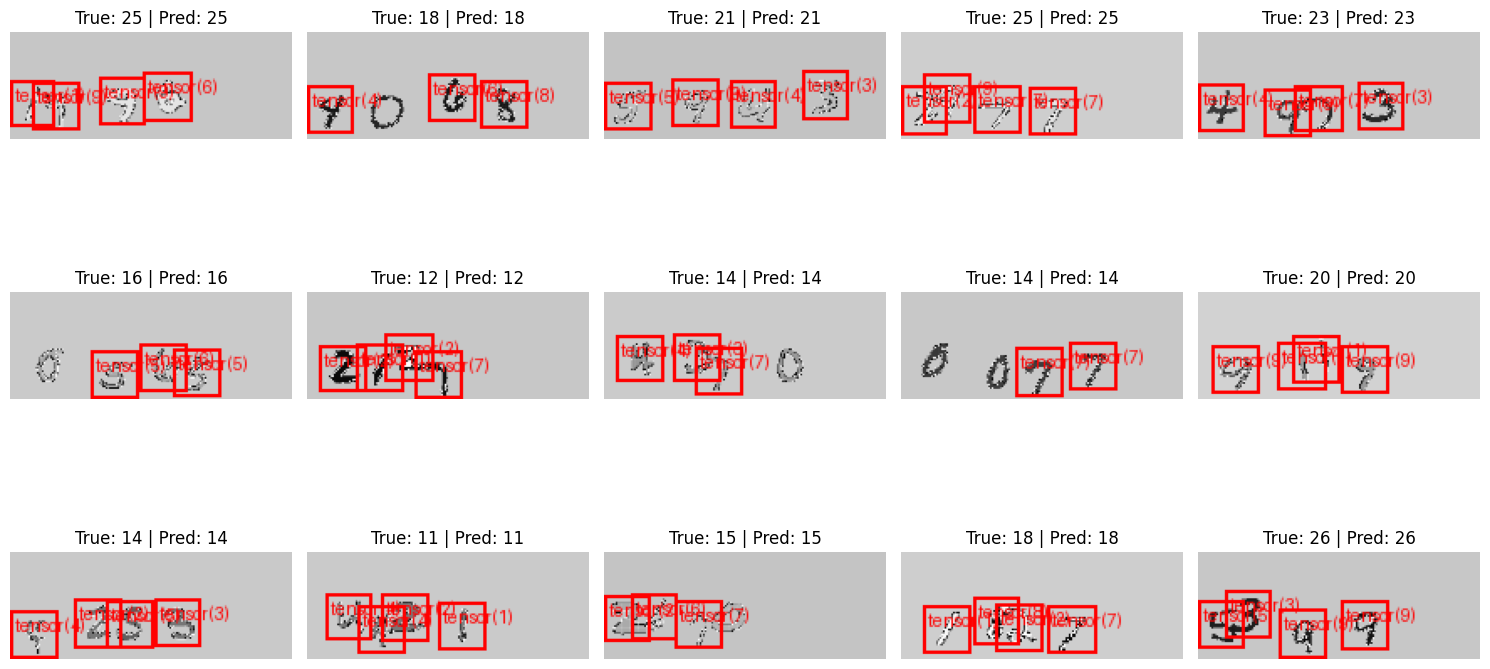

In [6]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm

# Initialize variables for accuracy and statistics
total_samples = 0
correct_predictions = 0
errors = []
images_to_plot = []
true_sums = []
predicted_sums = []
max_images = 15  

val_bar = tqdm(sumtestloader, desc=f"Epoch 0 test")

# Target image size for digit recognition
target_image = (28, 28)

for batch_idx, (images, sums) in enumerate(val_bar):
    th.cuda.empty_cache()
    model.eval()
    with th.no_grad():
        predictions = model(images.to(device))  
    
    batch_accuracy = 0
    batch_errors = []
    for i, pred in enumerate(predictions):
        boxes = pred['boxes'].detach().cpu().to(th.int)
        labels = pred['labels'].detach().cpu()
        scores = pred['scores'].detach().cpu()
        img = images[i].detach().cpu()

        if img.shape[0] == 1: 
            img = img.repeat(3, 1, 1)

        pred_sum = 0
        digits = []

        for j, box in enumerate(boxes):
            if scores[j] > 0.9:
                # img_subset = np.copy(img[0, box[1]:box[3], box[0]:box[2]])
                # pady, padx = 28 - img_subset.shape[0], 28 - img_subset.shape[1]
                # padding = (pady if pady > 0 else 0, padx if padx > 0 else 0)
                # img_subset = th.tensor(np.pad(img_subset, padding), dtype=th.float)
                # digit = th.argmax(recognizer((img_subset[:28, :28]).unsqueeze(0).unsqueeze(0).to(device)))
                digits.append(labels[j])#digits.append(digit.item())
                pred_sum+=labels[j]#pred_sum += digit.item()

        # Calculate statistics
        error = pred_sum - sums[i].item()
        batch_errors.append(error)
        if pred_sum == sums[i].item():
            batch_accuracy += 1

        # Store results for plotting later
        if len(images_to_plot) < max_images:
            drawn = draw_bounding_boxes(
                img, 
                boxes[scores > 0.9], 
                labels=[str(d) for d in digits], 
                colors="red", 
                width=2
            )
            images_to_plot.append(to_pil_image(drawn))
            true_sums.append(sums[i].item())
            predicted_sums.append(pred_sum)

    # Update running accuracy
    total_samples += len(predictions)
    correct_predictions += batch_accuracy
    errors.extend(batch_errors)
    val_bar.set_postfix(accuracy=correct_predictions / total_samples)

    # Plot every 3 batches
    if (batch_idx + 1) % 100 == 0:
        num_cols = 5
        num_rows = (len(images_to_plot) + num_cols - 1) // num_cols
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
        axes = axes.flatten()

        for ax, img, true_sum, pred_sum in zip(axes, images_to_plot, true_sums, predicted_sums):
            ax.imshow(img)
            ax.set_title(f"True: {true_sum} | Pred: {pred_sum}")
            ax.axis("off")

        # Hide any extra subplots
        for ax in axes[len(images_to_plot):]:
            ax.axis("off")

        plt.tight_layout()
        plt.show()

# Final Accuracy
overall_accuracy = correct_predictions / total_samples

# Error Statistics
mean_error = np.mean(errors)
std_error = np.std(errors)
num_errors = len(errors)

# Print Summary
print(f"Total Samples: {total_samples}")
print(f"Correct Predictions: {correct_predictions}")
print(f"Overall Accuracy: {overall_accuracy:.2f}")
print(f"Mean Error: {mean_error:.2f}")
print(f"Standard Deviation of Error: {std_error:.2f}")
print(f"Total Errors: {num_errors}")

# Plot Error Distribution
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=20, edgecolor='black')
plt.title("Error Distribution")
plt.xlabel("Error (Predicted Sum - True Sum)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

# Final Plot of Images
num_cols = 5  # Number of columns in the grid
num_rows = (max_images + num_cols - 1) // num_cols  # Calculate rows required

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()

for ax, img, true_sum, pred_sum in zip(axes, images_to_plot, true_sums, predicted_sums):
    ax.imshow(img)
    ax.set_title(f"True: {true_sum} | Pred: {pred_sum}")
    ax.axis("off")

# Hide any extra subplots
for ax in axes[len(images_to_plot):]:
    ax.axis("off")

plt.tight_layout()
plt.show()
